In [76]:
import cv2
import pytesseract
import re


def extract_frames(video_path, interval_frames=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % interval_frames == 0:
            frames.append((frame_idx, frame.copy()))
        frame_idx += 1

    cap.release()
    return frames

def read_scoreboard_text(scoreboard_image):
    gray = cv2.cvtColor(scoreboard_image, cv2.COLOR_BGR2GRAY)
    # Optional preprocessing
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    config = '--psm 6'  # Assume uniform block of text
    return pytesseract.image_to_string(thresh, config=config)

def parse_half(text):
    # Lowercase for consistency
    text = text.lower()

    # Fix common OCR variants of "1st"
    text = text.replace("ist", "1st")
    text = text.replace("it", "1st")
    text = text.replace("i st", "1st")
    text = text.replace("i", "1st")
    text = text.replace("1 st", "1st")
    text = text.replace("| st", "1st")

    # Now extract
    match = re.search(r'\b(1st|2nd|3rd|4th|ot)\b', text)
    return match.group(0) if match else None



def parse_scoreboard(text):
    time_match = re.search(r'\d{1,2}[:\.]\d{2}', text)
    scores = [int(s) for s in re.findall(r'\b\d{1,3}\b', text)]

    return {
        'time': time_match.group(0).replace('.', ':') if time_match else None,
        'home_score': scores[0] if len(scores) > 1 else None,
        'away_score': scores[1] if len(scores) > 1 else None,
        'half': parse_half(text)
    }


def crop_scoreboard(frame, x, y, w, h):
    # Adjust these numbers after inspecting frame
    return frame[y:y+h, x:x+w]



In [77]:
video_path = '/Users/thenning/Downloads/output.mp4'
frames = extract_frames(video_path, interval_frames=30)


x, y, w, h = 348, 622, 590, 55
for idx, frame in frames:
    
    scoreboard = crop_scoreboard(frame, x, y, w, h)
    text = read_scoreboard_text(scoreboard)
    parsed = parse_scoreboard(text)
    if parsed['half'] is None:
        print(f"\n⚠️ Frame {idx} is missing 'half'")
        print("--- OCR Raw Text ---")
        print(text)
        print("---------------------")
    print(f"Frame {idx}: {parsed}")


Frame 0: {'time': '19:45', 'home_score': 19, 'away_score': 45, 'half': '1st'}
Frame 30: {'time': '19:44', 'home_score': 1, 'away_score': 19, 'half': '1st'}
Frame 60: {'time': '19:45', 'home_score': 19, 'away_score': 45, 'half': '1st'}
Frame 90: {'time': '19:42', 'home_score': 19, 'away_score': 42, 'half': '1st'}
Frame 120: {'time': '19:41', 'home_score': 19, 'away_score': 41, 'half': '1st'}
Frame 150: {'time': '19:40', 'home_score': 19, 'away_score': 40, 'half': '1st'}
Frame 180: {'time': '19:39', 'home_score': 19, 'away_score': 39, 'half': '1st'}
Frame 210: {'time': '19:38', 'home_score': 19, 'away_score': 38, 'half': '1st'}
Frame 240: {'time': '19:37', 'home_score': 19, 'away_score': 37, 'half': '1st'}
Frame 270: {'time': '19:36', 'home_score': 19, 'away_score': 36, 'half': '1st'}
Frame 300: {'time': '19:35', 'home_score': 19, 'away_score': 35, 'half': '1st'}
Frame 330: {'time': '19:34', 'home_score': 19, 'away_score': 34, 'half': '1st'}
Frame 360: {'time': '19:33', 'home_score': 19,

# Show Scoreboard

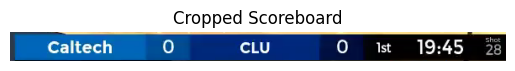

In [95]:
import matplotlib.pyplot as plt

x, y, w, h = 348, 622, 590, 35
def show_scoreboard(scoreboard_img):
    plt.imshow(cv2.cvtColor(scoreboard_img, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Scoreboard")
    plt.axis('off')
    plt.show()

scoreboard = crop_scoreboard(frames[0][1],x,y,w,h)
show_scoreboard(scoreboard)


In [89]:
import cv2
import pytesseract
import re
from datetime import datetime
import csv


def extract_frames(video_path, interval_frames=30):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % interval_frames == 0:
            frames.append((frame_idx, frame.copy()))
        frame_idx += 1

    cap.release()
    return frames


def read_scoreboard_text(scoreboard_image):
    gray = cv2.cvtColor(scoreboard_image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    config = '--psm 6'
    return pytesseract.image_to_string(thresh, config=config)


def parse_scoreboard(text):
    # ── 1.  extract the game clock ────────────────────────────────────────────────
    time_match = re.search(r'\d{1,2}[:\.]\d{2}', text)
    time_str   = time_match.group(0).replace('.', ':') if time_match else None

    # ── 2.  basic clean-up of OCR noise ───────────────────────────────────────────
    txt = (
        text.lower()
            .replace('\n', ' ')
            .replace('calteck', 'caltech')   # common OCR slip
            .replace('°', ' ')               # stray symbol between name & score
            .replace('o', '0')               # “O” → “0” for zero scores
    )
    # normalise multiple spaces
    txt = re.sub(r'\s+', ' ', txt)

    # ── 3-A.  try to capture BOTH scores in one regex (Caltech first) ────────────
    m = re.search(r'caltech[^\d]{0,10}(\d{1,3}).{0,20}?clu[^\d]{0,10}(\d{1,3})', txt)
    if m:
        home, away = int(m.group(1)), int(m.group(2))
    else:
        # ── 3-B.  try the reverse order (in case layout flips) ───────────────────
        m = re.search(r'clu[^\d]{0,10}(\d{1,3}).{0,20}?caltech[^\d]{0,10}(\d{1,3})', txt)
        if m:
            home, away = int(m.group(2)), int(m.group(1))  # swap because CLU came first
        else:
            # ── 3-C.  fall back to the older “nearest number to team-name” logic ─
            home = away = None
            cal_m = re.search(r'caltech[^\d]{0,3}(\d{1,3})', txt)
            clu_m = re.search(r'clu[^\d]{0,3}(\d{1,3})',     txt)
            if cal_m:
                home = int(cal_m.group(1))
            if clu_m:
                away = int(clu_m.group(1))

            # if one score is still missing, assume it’s zero
            if home is None and away is not None:
                home = 0
            if away is None and home is not None:
                away = 0

    return {'time': time_str, 'home_score': home, 'away_score': away}


def parse_time_str(t):
    """Convert 'MM:SS' string to total seconds"""
    try:
        minutes, seconds = map(int, t.replace('.', ':').split(':'))
        return minutes * 60 + seconds
    except:
        return None


def crop_scoreboard(frame, x, y, w, h):
    return frame[y:y+h, x:x+w]


def analyze_video(video_path, crop_coords, interval_frames=30, output_csv="scoreboard_log.csv"):
    frames = extract_frames(video_path, interval_frames)
    x, y, w, h = crop_coords

    current_half = 1
    prev_time_sec = None
    parsed_frames = []

    for idx, frame in frames:
        scoreboard_img = crop_scoreboard(frame, x, y, w, h)
        text = read_scoreboard_text(scoreboard_img)
        parsed = parse_scoreboard(text)
        parsed['frame'] = idx

        time_sec = parse_time_str(parsed['time'])

        # Detect half switch based on time reset
        if prev_time_sec is not None and time_sec is not None:
            if time_sec > prev_time_sec + 60:  # Buffer for OCR noise
                current_half += 1
                print(f"⏱️  New half detected at Frame {idx} (clock: {parsed['time']})")

        prev_time_sec = time_sec if time_sec is not None else prev_time_sec
        parsed['half'] = current_half
        parsed_frames.append(parsed)

        print(f"Frame {idx}: {parsed}")

    # Optional: Save to CSV
    with open(output_csv, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=["frame", "time", "home_score", "away_score", "half"])
        writer.writeheader()
        writer.writerows(parsed_frames)

    print(f"\n✅ Done! Results saved to {output_csv}")


# === USAGE ===
video_path = '/Users/thenning/Downloads/output.mp4'
crop_coords = (348, 622, 590, 55)  # x, y, w, h — adjust as needed

analyze_video(video_path, crop_coords)


Frame 0: {'time': '19:45', 'home_score': 0, 'away_score': 0, 'frame': 0, 'half': 1}
Frame 30: {'time': '19:44', 'home_score': 0, 'away_score': 0, 'frame': 30, 'half': 1}
Frame 60: {'time': '19:45', 'home_score': 0, 'away_score': 0, 'frame': 60, 'half': 1}
Frame 90: {'time': '19:42', 'home_score': 0, 'away_score': 0, 'frame': 90, 'half': 1}
Frame 120: {'time': '19:41', 'home_score': 0, 'away_score': 0, 'frame': 120, 'half': 1}
Frame 150: {'time': '19:40', 'home_score': 0, 'away_score': 0, 'frame': 150, 'half': 1}
Frame 180: {'time': '19:39', 'home_score': 0, 'away_score': 0, 'frame': 180, 'half': 1}
Frame 210: {'time': '19:38', 'home_score': 0, 'away_score': 0, 'frame': 210, 'half': 1}
Frame 240: {'time': '19:37', 'home_score': 0, 'away_score': 0, 'frame': 240, 'half': 1}
Frame 270: {'time': '19:36', 'home_score': 0, 'away_score': 0, 'frame': 270, 'half': 1}
Frame 300: {'time': '19:35', 'home_score': 0, 'away_score': 0, 'frame': 300, 'half': 1}
Frame 330: {'time': '19:34', 'home_score':

In [ ]:
"""
robust_scoreboard_ocr.py
------------------------
End-to-end extraction of clock, scores, and half number from a basketball
broadcast with a static scoreboard bar.
"""

import cv2, pytesseract, re, csv
from collections import deque

# ═════════════════════════════ OCR helpers ════════════════════════════════════
def crop_scoreboard(frame, x, y, w, h):
    """Crop the fixed ROI where the scoreboard lives."""
    return frame[y:y + h, x:x + w]


def read_scoreboard_text(img):
    """Grayscale + binary threshold → Tesseract OCR."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    return pytesseract.image_to_string(th, config='--psm 6')


def parse_scoreboard(text: str):
    """
    Return dict with raw clock string and the **raw** OCR digits near team names.
    Three-tier strategy:
        ①  Caltech <digits> … CLU <digits>
        ②  CLU <digits> … Caltech <digits>
        ③  nearest-number fallback for each team.
    """
    # clock
    tm  = re.search(r'\d{1,2}[:\.]\d{2}', text)
    clk = tm.group(0).replace('.', ':') if tm else None

    # canonicalise text
    txt = (text.lower()
                .replace('\n', ' ')
                .replace('calteck', 'caltech')
                .replace('°', ' ')
                .replace('o', '0'))            # CLU O  → 0
    txt = re.sub(r'\s+', ' ', txt)

    # joint pattern
    m = re.search(r'caltech[^\d]{0,10}(\d{1,3}).{0,20}?clu[^\d]{0,10}(\d{1,3})', txt)
    if m:
        home, away = int(m.group(1)), int(m.group(2))
    else:
        # reversed
        r = re.search(r'clu[^\d]{0,10}(\d{1,3}).{0,20}?caltech[^\d]{0,10}(\d{1,3})', txt)
        if r:
            home, away = int(r.group(2)), int(r.group(1))
        else:
            home = away = None
            c = re.search(r'caltech[^\d]{0,3}(\d{1,3})', txt)
            l = re.search(r'clu[^\d]{0,3}(\d{1,3})', txt)
            if c: home = int(c.group(1))
            if l: away = int(l.group(1))

    return {"time": clk, "home_score": home, "away_score": away}


def parse_time_str(t: str | None):
    """Convert 'MM:SS' string → total seconds."""
    if not t:
        return None
    m, s = map(int, t.split(':'))
    return m * 60 + s


# ═════════════════════════════ Clock tracker ══════════════════════════════════
class ClockTracker:
    """
    Filters OCR noise and detects new halves.

    confirm_frames      – how many consecutive frames an upward tick must
                          persist before acceptance (default 3).
    noise_threshold     – max seconds treated as OCR noise (default 2 s).
    half_reset_threshold– upward jump ≥ this triggers a new half (default 90 s).
    """
    def __init__(self, cf=3, nt=2, ht=90):
        self.hist = deque(maxlen=cf)
        self.cu = self.cc = None     # candidate upward value + counter
        self.half = 1
        self.nt, self.ht = nt, ht

    def _commit(self, t):
        self.hist.append(t)
        self.cu = self.cc = None

    def update(self, t_now):
        last = self.hist[-1] if self.hist else None

        # first reading
        if last is None:
            self._commit(t_now)
            return t_now, self.half

        # no OCR value → keep last
        if t_now is None:
            return last, self.half

        # countdown or equal
        if t_now <= last:
            self._commit(t_now)
            return t_now, self.half

        # upward jump
        jump = t_now - last

        # big jump ⇒ new half
        if jump >= self.ht:
            self.half += 1
            self.hist.clear()
            self._commit(t_now)
            return t_now, self.half

        # small jump ⇒ maybe noise
        if jump <= self.nt:
            if self.cu == t_now:
                self.cc += 1
            else:
                self.cu, self.cc = t_now, 1

            if self.cc >= self.hist.maxlen:   # persisted → accept
                self._commit(t_now)
                return t_now, self.half
            return last, self.half            # still noise

        # mid-sized jump ⇒ accept immediately
        self._commit(t_now)
        return t_now, self.half


# ═════════════════════════════ Score tracker ══════════════════════════════════
class ScoreTracker:
    """
    Keeps scores monotone *unless* a lower value persists for
    `confirm_frames` snapshots (referee correction).
    """
    def __init__(self, confirm_frames: int = 3):
        self.home = self.away = 0            # last confirmed scores
        self.cand_h = self.cand_a = None     # candidate downward scores
        self.cnt_h = self.cnt_a = 0
        self.need = confirm_frames

    def _update_side(self, new_val, last_val, cand_val, cand_cnt):
        if new_val is None:
            return last_val, cand_val, cand_cnt

        # increase → accept instantly
        if new_val > last_val:
            return new_val, None, 0

        # potential downward correction
        if new_val < last_val:
            if new_val == cand_val:
                cand_cnt += 1
            else:
                cand_val, cand_cnt = new_val, 1

            if cand_cnt >= self.need:        # sustained ⇒ accept
                return new_val, None, 0
            return last_val, cand_val, cand_cnt  # still probing

        # equal
        return last_val, None, 0

    def clean(self, h_new, a_new):
        self.home, self.cand_h, self.cnt_h = self._update_side(
            h_new, self.home, self.cand_h, self.cnt_h
        )
        self.away, self.cand_a, self.cnt_a = self._update_side(
            a_new, self.away, self.cand_a, self.cnt_a
        )
        return self.home, self.away


# ═════════════════════════════ Main pipeline ══════════════════════════════════
def analyze(video_path,
            crop_coords,
            frame_skip=30,
            csv_out="scoreboard_log.csv"):
    """
    Full loop: sample frames → OCR → clean clock & scores → console + CSV.
    """
    x, y, w, h = crop_coords
    cap = cv2.VideoCapture(video_path)

    idx = 0
    clock_filter = ClockTracker()
    score_filter = ScoreTracker()
    rows = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        idx += 1
        if idx % frame_skip:           # skip frames for speed
            continue

        roi  = crop_scoreboard(frame, x, y, w, h)
        text = read_scoreboard_text(roi)
        raw  = parse_scoreboard(text)

        # --- score stabilisation ---------------------------------------------
        h_sc, a_sc = score_filter.clean(raw["home_score"], raw["away_score"])

        # --- clock stabilisation & half tracking -----------------------------
        raw_sec = parse_time_str(raw["time"])
        clean_sec, cur_half = clock_filter.update(raw_sec)
        clean_time = (f"{clean_sec//60:02d}:{clean_sec%60:02d}"
                      if clean_sec is not None else None)

        record = {
            "frame": idx,
            "time": clean_time,
            "home_score": h_sc,
            "away_score": a_sc,
            "half": cur_half
        }
        rows.append(record)
        print(f"Frame {idx}: {record}")

    cap.release()

    # save CSV
    with open(csv_out, "w", newline="") as f:
        csv.DictWriter(f, fieldnames=rows[0].keys()).writerows(rows)

    print(f"\n✅ Finished – {len(rows)} snapshots written to «{csv_out}»")


# ═════════════════════════════ User settings ══════════════════════════════════
if __name__ == "__main__":
    VIDEO_PATH  = "/Users/thenning/Downloads/output.mp4"
    CROP_COORDS = (348, 622, 590, 55)   # ← adjust once (x, y, w, h)
    FRAME_SKIP  = 30                    # 30 → sample ~1 fps if source = 30 fps

    analyze(VIDEO_PATH, CROP_COORDS, frame_skip=FRAME_SKIP)


Frame 30: {'frame': 30, 'time': '19:44', 'home_score': 0, 'away_score': 0, 'half': 1}
Frame 60: {'frame': 60, 'time': '19:43', 'home_score': 0, 'away_score': 0, 'half': 1}
Frame 90: {'frame': 90, 'time': '19:42', 'home_score': 0, 'away_score': 0, 'half': 1}
Frame 120: {'frame': 120, 'time': '19:41', 'home_score': 0, 'away_score': 0, 'half': 1}
Frame 150: {'frame': 150, 'time': '19:40', 'home_score': 0, 'away_score': 0, 'half': 1}
Frame 180: {'frame': 180, 'time': '19:39', 'home_score': 0, 'away_score': 0, 'half': 1}
Frame 210: {'frame': 210, 'time': '19:38', 'home_score': 0, 'away_score': 0, 'half': 1}
Frame 240: {'frame': 240, 'time': '19:37', 'home_score': 0, 'away_score': 0, 'half': 1}
Frame 270: {'frame': 270, 'time': '19:36', 'home_score': 0, 'away_score': 0, 'half': 1}
Frame 300: {'frame': 300, 'time': '19:35', 'home_score': 0, 'away_score': 0, 'half': 1}
Frame 330: {'frame': 330, 'time': '19:34', 'home_score': 0, 'away_score': 0, 'half': 1}
Frame 360: {'frame': 360, 'time': '19:

# Code; need to input Home; Away

In [ ]:
"""
robust_scoreboard_ocr.py
------------------------
End-to-end extraction of clock, scores, and half number from a basketball
broadcast with a static scoreboard bar.

Key features
------------
◆ User-defined HOME / AWAY team labels
◆ Robust clock tracker  – ignores 1-frame up-ticks; new half on big jump
◆ Ref-aware score tracker – accepts ref corrections only if persistent
◆ CSV output  [frame, time, <HOME>, <AWAY>, half]
"""

import cv2, pytesseract, re, csv
from collections import deque

# ═════════════════════════════ User settings ══════════════════════════════════
VIDEO_PATH  = "/Users/thenning/Downloads/output.mp4"
CROP_COORDS = (348, 622, 590, 55)      # x, y, w, h – adjust once
FRAME_SKIP  = 30                       # 30 → sample ≈1 fps if source = 30 fps

HOME_NAME   = "Caltech"                # ← EXACT on-screen spelling / case
AWAY_NAME   = "Clu"                    # ← e.g. "CLU", "Pomona", "Cms", …

# ───────────────────────────── OCR helpers ────────────────────────────────────
def crop_scoreboard(frame, x, y, w, h):
    return frame[y:y + h, x:x + w]

def read_ocr(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    return pytesseract.image_to_string(th, config="--psm 6")

# ───────────────────────────── parser ─────────────────────────────────────────
def parse_scoreboard(text: str, home_tag: str, away_tag: str):
    """
    Finds '<home_tag> <digits>' and '<away_tag> <digits>' (case-insensitive)
    in the BLUE bar (text before the clock).
    """
    # 1) locate clock
    m_clk = re.search(r"\d{1,2}[:\.]\d{2}", text)
    clock = m_clk.group(0).replace(".", ":") if m_clk else None

    # 2) canonicalise & strip brown row (everything after the clock)
    lc = (text.lower()
               .replace("\n", " ")
               .replace("calteck", "caltech")  # common slip
               .replace("°", " ")
               .replace("o", "0"))
    lc = re.sub(r"\s+", " ", lc)
    if m_clk:
        lc = lc[:m_clk.start()]               # keep blue bar only

    def grab(tag):
        m = re.search(fr"{tag.lower()}\D{{0,3}}(\d{{1,3}})", lc)
        return int(m.group(1)) if m else None

    h_score = grab(home_tag)
    a_score = grab(away_tag)
    return {"time": clock, "home_score": h_score, "away_score": a_score}

def t_to_sec(t):
    return None if t is None else int(t[:t.find(":")])*60 + int(t[-2:])

# ──────────────────────── robust clock tracker ────────────────────────────────
class ClockTracker:
    def __init__(self, confirm=3, noise=2, half_jump=90):
        self.hist = deque(maxlen=confirm)
        self.cand_val, self.cand_cnt = None, 0
        self.half = 1
        self.noise, self.half_jump = noise, half_jump
    def _commit(self, t):
        self.hist.append(t); self.cand_val, self.cand_cnt = None, 0
    def update(self, t):
        last = self.hist[-1] if self.hist else None
        if last is None: self._commit(t); return t, self.half
        if t is None:    return last, self.half
        if t <= last:    self._commit(t); return t, self.half
        jump = t - last
        if jump >= self.half_jump:
            self.half += 1; self.hist.clear(); self._commit(t); return t, self.half
        if jump <= self.noise:                      # need persistence
            if self.cand_val == t: self.cand_cnt += 1
            else: self.cand_val, self.cand_cnt = t, 1
            if self.cand_cnt >= self.hist.maxlen:
                self._commit(t); return t, self.half
            return last, self.half                 # treat as noise
        self._commit(t); return t, self.half       # mid-sized jump

# ──────────────────────── referee-aware score tracker ─────────────────────────
class ScoreTracker:
    def __init__(self, confirm=3):
        self.last  = {HOME_NAME: 0, AWAY_NAME: 0}   # initial scores
        self.cand  = {}                             # {team: (score,cnt)}
        self.need  = confirm
    def _update(self, team, new_val):
        cur = self.last[team]
        if new_val is None: return cur
        if new_val > cur:                # basket ↑
            self.last[team] = new_val; self.cand.pop(team, None); return new_val
        if new_val < cur:                # possible correction ↓
            cand, cnt = self.cand.get(team, (new_val, 0))
            cand = new_val if cand != new_val else cand
            cnt  = cnt + 1 if cand == new_val else 1
            if cnt >= self.need:
                self.last[team] = new_val; self.cand.pop(team, None); return new_val
            self.cand[team] = (cand, cnt); return cur
        return cur                        # equal
    def clean(self, h_new, a_new):
        return (self._update(HOME_NAME, h_new),
                self._update(AWAY_NAME, a_new))

# ──────────────────────────── main routine ────────────────────────────────────
def analyze(video, crop, skip=30, csv_out="scoreboard.csv"):
    x,y,w,h = crop
    cap = cv2.VideoCapture(video)
    clockF, scoreF = ClockTracker(), ScoreTracker()
    rows = []
    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        frame_idx += 1
        if frame_idx % skip: continue

        text = read_ocr(crop_scoreboard(frame,x,y,w,h))
        raw  = parse_scoreboard(text, HOME_NAME, AWAY_NAME)

        # scores
        h_score, a_score = scoreF.clean(raw["home_score"], raw["away_score"])
        # clock / half
        sec, half = clockF.update(t_to_sec(raw["time"]))
        clock_str = None if sec is None else f"{sec//60:02d}:{sec%60:02d}"

        rec = {"frame": frame_idx, "time": clock_str, HOME_NAME: h_score,
               AWAY_NAME: a_score, "half": half}
        rows.append(rec)
        print(rec)

    cap.release()
    # write CSV
    with open(csv_out,"w",newline="") as f:
        csv.DictWriter(f, fieldnames=["frame","time",HOME_NAME,AWAY_NAME,"half"]
                      ).writeheader()
        csv.DictWriter(f, fieldnames=["frame","time",HOME_NAME,AWAY_NAME,"half"]
                      ).writerows(rows)
    print(f"\n✅ Saved {len(rows)} rows → {csv_out}")

# ───────────────────────────── run! ───────────────────────────────────────────
if __name__ == "__main__":
    analyze(VIDEO_PATH, CROP_COORDS, skip=FRAME_SKIP)


{'frame': 30, 'time': '19:44', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 60, 'time': '19:43', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 90, 'time': '19:42', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 120, 'time': '19:41', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 150, 'time': '19:40', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 180, 'time': '19:39', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 210, 'time': '19:38', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 240, 'time': '19:37', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 270, 'time': '19:36', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 300, 'time': '19:35', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 330, 'time': '19:34', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 360, 'time': '19:33', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 390, 'time': '19:32', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 420, 'time': '19:31', 'Caltech': 0, 'Clu': 0, 'half': 1}
{'frame': 450, 'time': '19:30', 'Caltech': 0, 'Clu': 0, 'half': 1